$$
\begin{array}{c}
\hline
\\
\mathbf{\text{Programming Assignment 3}} \\
\\
\hline
\end{array}
$$

$$
\mathbf{\text{Wonjun Park}} \\
\text{Computer Science and Engineering} \\
\text{University of Texas at Arlington} \\
\text{Arlington, TX, USA} \\
\text{wxp7177@mavs.uta.edu}
$$

***Abstract*** \
This Jupyter Notebook implemented KMeans and Agglomerative Hierarchical Clusterings for a given dataset `wine.csv`. Specifically, the KMeans algorithm was implemented from scratch using KMeans++ for initialization, and the Agglomerative Hierarchical Clustering was implemented using a scikit-learn library. JAX, a NumPy-like library for accelerated numerical computing with JIT (Just-In-Time) compilation, was adopted for the implementation of KMeans algorithm. The notebook includes the code of those implementations, the result of KMeans regarding the SSE (Sum of Squared Errors) values with respect to the number of clusters in both string and plot forms, and the result of Agglomerative Hierarchical Clusterings with the dendrogram. At the end of the notebook, a good value of 
$K$ was suggested based on the Elbow method.

In [1]:
from jax import Array
from jax._src.random import KeyArray

import pandas as pd
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import random

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def set_seed(seed: int = 42) -> KeyArray:
    """
    Set the seed for reproducibility.

    Parameters
    ----------
    seed: int - The seed value

    Returns
    -------
    key: jax.random.key - The key for reproducibility for JAX
    """

    random.seed(seed)
    np.random.seed(seed)

    key = jax.random.key(seed)

    return key


def load_data(path: str = "wine.csv") -> tuple[jnp.ndarray, jnp.ndarray]:
    """
    Load the data from the given path.

    Parameters
    ----------
    path: str - The path to the data file

    Returns
    -------
    X: jnp.ndarray - The features of the data
    y: jnp.ndarray - The target of the data
    """
    data = pd.read_csv(path)

    X = data.drop("Wine", axis=1)
    y = data["Wine"]

    X = jnp.array(X)
    y = jnp.array(y)

    return X, y


def plot_SSE(history: list):
    """
    Plot the SSE with respect to the K values

    Parameters
    ----------
    history: list - The history of SSE values with respect to K values
    """
    k = [k for k, _ in history]
    sse_history = [sse for _, sse in history]

    # sse_history_plot = np.array(sse_history)

    plt.plot(range(len(sse_history)), sse_history, marker="o")
    plt.xticks(
        range(len(sse_history)),
        k,
    )

    plt.title("SSE with K values")
    plt.xlabel("K")
    plt.ylabel("SSE")

    plt.show()


def plot_dendrogram(linkage: np.ndarray):
    """
    Plot the dendrogram for the given linkage matrix

    Parameters
    ----------
    linkage: list - The linkage matrix
    """
    plt.figure(figsize=(10, 7))

    dendrogram(linkage)

    plt.title("Dendrogram")
    plt.xlabel("Index")
    plt.ylabel("Distance")

    plt.show()

In [3]:
@jit
def _euclidean_distances(A, B) -> Array:
    """
    Compute the Euclidean distances between two sets of points.

    Parameters
    ----------
    A: jnp.ndarray - The first set of points
    B: jnp.ndarray - The second set of points

    Returns
    -------
    distances: jnp.ndarray - The Euclidean distances between two sets of points
    """
    distances = jnp.sqrt(
        jnp.sum(
            (A[:, None, :] - B[None, :, :]) ** 2,
            axis=-1,
        )
    )
    return distances

In [4]:
@jit
def _weighted_choice(key, a, p):
    """
    Choose a random element from a with the probabilities p.

    Parameters
    ----------
    key: jax.random.KeyArray - The key for reproducibility
    a: jnp.ndarray - The array of elements
    p: jnp.ndarray - The array of probabilities

    Returns
    -------
    a[idx]: jnp.ndarray - The random element from a with the probabilities p
    """
    cumulative_probs = jnp.cumsum(p)
    r = jax.random.uniform(key, ()) * cumulative_probs[-1]
    idx = jnp.searchsorted(cumulative_probs, r, side="right")

    return a[idx]


@jit
def _assign_clusters(distances) -> Array:
    """
    Assign each data point to the nearest centroid.

    Parameters
    ----------
    distances: jnp.ndarray - The Euclidean distances between the data points and the centroids

    Returns
    -------
    labels: jnp.ndarray - The assigned cluster labels
    """
    return jnp.argmin(distances, axis=1)


@jit
def _compute_SSE(X, centroids, labels) -> Array:
    """
    Compute the sum of squared errors (SSE) of the current KMeans model.

    Returns
    -------
    SSE: float - The sum of squared errors (SSE) of the current KMeans model
    """
    assigned_centroids = centroids[labels]
    errors = X - assigned_centroids
    squared_errors = jnp.sum(errors**2, axis=1)

    return jnp.sum(squared_errors)


class KMeans:
    def __init__(self, key, n_clusters=3, max_iter=0) -> None:
        """
        Initialize the KMeans class.

        Parameters
        ----------
        key: jax.random.KeyArray - The key for reproducibility
        n_clusters: int - The number of clusters
        max_iter: int - The maximum number of iterations
        """
        assert n_clusters > 0, "The number of clusters must be larger than 0"

        self.__key = key
        self.__n_clusters: int = n_clusters
        self.__max_iter: int = max_iter

        self.__centroids: Array = jnp.array([])
        self.__labels: Array = jnp.array([])
        self.__X: Array = jnp.array([])
        self.__SSE: Array = jnp.array([])

    def __init_centroids(self) -> Array:
        """
        Initialize the centroids using the KMeans++ algorithm.

        Returns
        -------
        centroids: jnp.ndarray - The initialized centroids
        """
        n_clusters, X = self.__n_clusters, self.__X

        n_samples = X.shape[0]
        keys = jax.random.split(self.__key, n_clusters)

        idx = jax.random.randint(keys[0], (), 0, n_samples)
        centroids = [X[idx]]

        for i in range(1, n_clusters):
            distances = jnp.min(
                jnp.stack([jnp.sum((X - c) ** 2, axis=1) for c in centroids], axis=1),
                axis=1,
            )
            total_distance = jnp.sum(distances)
            probabilities = distances / total_distance

            idx = _weighted_choice(keys[i], jnp.arange(n_samples), probabilities)
            centroids.append(X[idx])

        return jnp.array(centroids)

    def __compute_distances(self):
        """
        Compute the Euclidean distances between the data points and the centroids.

        Returns
        -------
        distances: jnp.ndarray - The Euclidean distances between the data points and the centroids
        """
        return _euclidean_distances(self.__X, self.__centroids)

    def __compute_new_centroids(self) -> Array:
        """
        Compute the new centroids based on the assigned clusters.

        Returns
        -------
        centroids: jnp.ndarray - The new centroids
        """
        X, labels, n_clusters = self.__X, self.__labels, self.__n_clusters

        centroids_sum = jax.ops.segment_sum(X, labels, num_segments=n_clusters)
        counts = jnp.bincount(labels, minlength=n_clusters).reshape(-1, 1)
        counts = jnp.where(counts == 0, 1, counts)
        centroids = centroids_sum / counts

        return centroids

    def fit(self, X):
        """
        Train the KMeans model to the given data.

        Parameters
        ----------
        X: jnp.ndarray - The data to fit the KMeans model

        Returns
        -------
        iter_num: int - The number of iterations to converge
        """
        self.__X: Array = X
        self.__centroids = self.__init_centroids()

        iter_num = 0
        for i in range(1, self.__max_iter + 1):
            iter_num = i

            distances = self.__compute_distances()
            self.__labels = _assign_clusters(distances)
            new_centroids: Array = self.__compute_new_centroids()

            if jnp.allclose(self.__centroids, new_centroids, atol=1e-6):
                break
            self.__centroids = new_centroids

        return iter_num

    def evaluate(self) -> Array:
        """
        Evaluate the KMeans model by computing the sum of squared errors (SSE).

        Returns
        -------
        float - The sum of squared errors (SSE) of the KMeans model
        """
        self.__SSE = _compute_SSE(self.__X, self.__centroids, self.__labels)

        return self.__SSE


For k = 2 After 5 iterations: SSE = 4543748.00
For k = 3 After 5 iterations: SSE = 2370689.50
For k = 4 After 5 iterations: SSE = 1337436.88
For k = 5 After 12 iterations: SSE = 965018.75
For k = 6 After 9 iterations: SSE = 690419.12
For k = 7 After 22 iterations: SSE = 414997.53
For k = 8 After 4 iterations: SSE = 329655.34


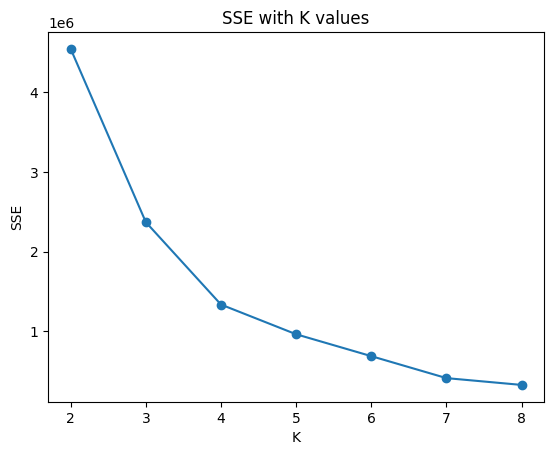

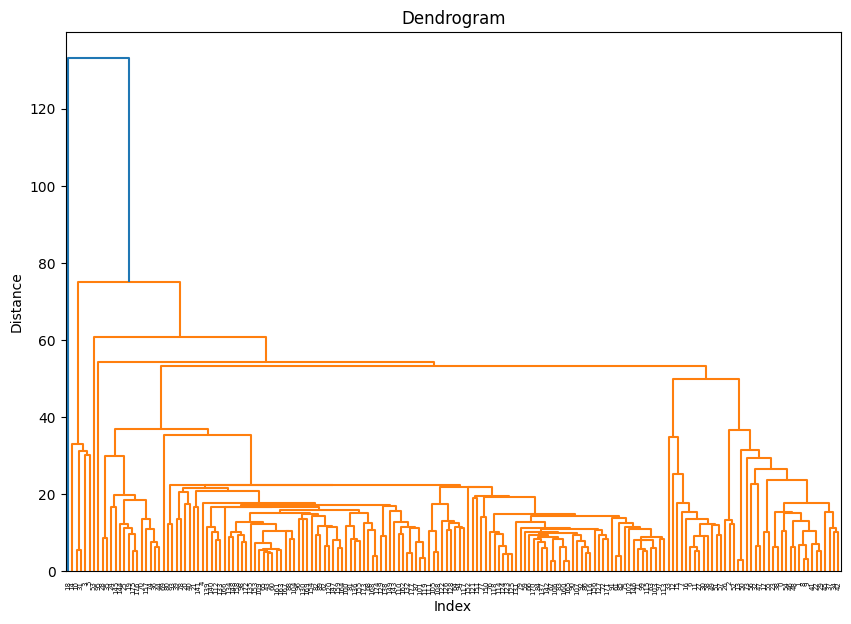

Silhouette Score: 0.48798203468322754


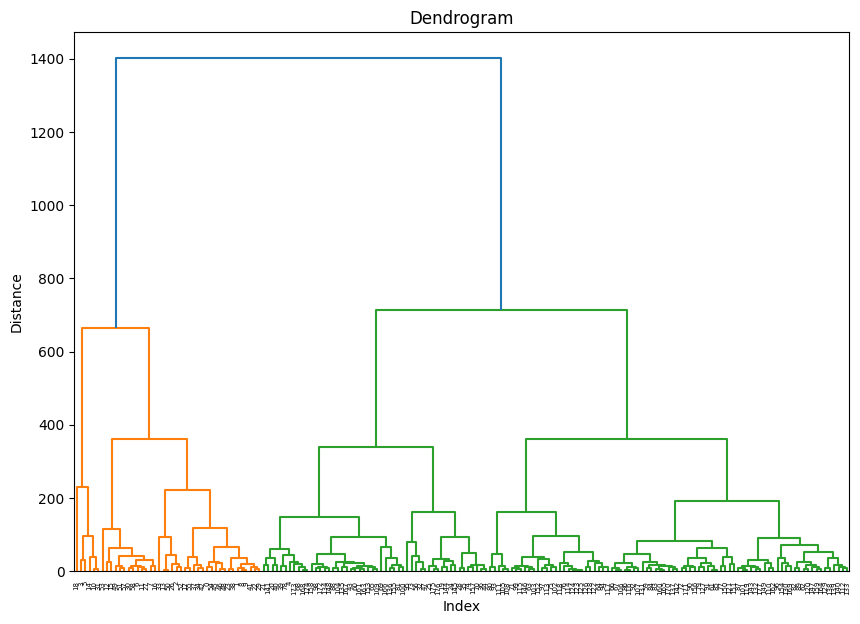

Silhouette Score: 0.5418973565101624


In [5]:
"""
Programming Assignment 3
CSE-5334 Data Mining, Fall 2024
Professor: Dr. Marnim Galib

Wonjun Park
UTA ID: 1002237177
Computer Science and Engineering, University of Texas at Arlington, Arlington, TX, USA
wxp7177@mavs.uta.edu
"""


def train_kmeans(X, K=3):
    kmeans = KMeans(key=key, n_clusters=K, max_iter=1000)

    iter_num = kmeans.fit(X)

    SSE = kmeans.evaluate()

    print(f"For k = {K} After {iter_num} iterations: SSE = {SSE:.2f}")

    return SSE


def train_agglomerative(X, method) -> tuple[np.ndarray, float]:
    agglomerative_clustering = AgglomerativeClustering(
        metric="euclidean", linkage=method, n_clusters=3
    )

    labels = agglomerative_clustering.fit_predict(X)
    silhouette_coef = silhouette_score(X, labels)

    linkage_matrix = linkage(X, method=method)

    return linkage_matrix, silhouette_coef


def main():
    X: Array = load_data()[0]

    """
    Task 1: KMeans Clustering
    """
    SSE_history = []
    for K in range(2, 9):
        SSE = train_kmeans(X, K)
        SSE_history.append((K, SSE))
    plot_SSE(SSE_history)

    """
    Task 2: Agglomerative Hierarchical Clustering
    """
    linkage_matrix, sihouette_score = train_agglomerative(X, "single")
    plot_dendrogram(linkage_matrix)
    print(f"Silhouette Score: {sihouette_score}")

    linkage_matrix, sihouette_score = train_agglomerative(X, "complete")
    plot_dendrogram(linkage_matrix)
    print(f"Silhouette Score: {sihouette_score}")


if __name__ == "__main__":
    key = set_seed(0)

    main()


Based on the Elbow method, the most good value of $K$ is 7 or 8. Plus, when extending the range of $K$ due to the ambiguity of the result, the volatility of SSE becomes small after 8.